#   Q18 Machine Learning Rolling Basis

In this example we predict whether the price will rise or fall by using supervised learning (Bayesian Ridge Regression). This template represents a starting point for developing a system which can take part to the **Q18 NASDAQ-100 Stock Long-Short contest**.

It consists of two parts.

* In the **first part** we just perform a global training of the time series using all time series data. We disregard the sequential aspect of the data and use also future data to train past data.

* In the **second part** we use the built-in backtester and perform training and prediction on a rolling basis in order to avoid forward looking. Please note that we are using a **specialized** version of the Quantiacs backtester which dramatically speeds up the the backtesting process by retraining your model on a regular basis.

**Features for learning**: we will use several technical indicators trying to capture different features. You can have a look at [**Technical Indicators**](https://quantiacs.com/documentation/en/user_guide/technical_indicators.html).

Please note that:

* Your trading algorithm can open short and long positions.

* At each point in time your algorithm can trade all or a subset of the stocks which at that point of time are or were part of the NASDAQ-100 stock index. Note that the composition of this set changes in time, and Quantiacs provides you with an appropriate filter function for selecting them.

* The Sharpe ratio of your system since January 1st, 2006, has to be larger than 1.

* Your system cannot be a copy of the current examples. We run a correlation filter on the submissions and detect duplicates.

* For simplicity we will use a single asset. It pays off to use more assets, ideally uncorrelated, and diversify your positions for a more solid Sharpe ratio.

More details on the rules can be found [here](https://quantiacs.com/contest).

**Need help?** Check the [**Documentation**](https://quantiacs.com/documentation/en/) and find solutions/report problems in the [**Forum**](https://quantiacs.com/community/categories) section.

**More help with Jupyter?** Check the official [**Jupyter**](https://jupyter.org/) page.

Once you are done, click on **Submit to the contest** and take part to our competitions.

API reference:

* **data**: check how to work with [data](https://quantiacs.com/documentation/en/reference/data_load_functions.html);

* **backtesting**: read how to run the [simulation](https://quantiacs.com/documentation/en/reference/evaluation.html) and check the results.

Need to use the optimizer function to automate tedious tasks?

* **optimization**: read more on our [article](https://quantiacs.com/community/topic/29/optimizing-and-monitoring-a-trading-system-with-quantiacs).

In [1]:
import logging

import xarray as xr  # xarray for data manipulation

import qnt.data as qndata     # functions for loading data
import qnt.backtester as qnbt # built-in backtester
import qnt.ta as qnta         # technical analysis library
import qnt.stats as qnstats   # statistical functions

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

np.seterr(divide = "ignore")

from qnt.ta.macd import macd
from qnt.ta.rsi  import rsi
from qnt.ta.stochastic import stochastic_k, stochastic, slow_stochastic

from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

In [2]:
# loading nasdaq-100 stock data
stocks_list = qndata.stocks.load_spx_list(min_date='2006-01-01')
stock_data = qndata.stocks.load_spx_data(min_date="2006-01-01", assets=stocks_list)

close = stock_data.sel(field="close").to_dataframe()
print(close.head())
print(close.columns)

fetched chunk 1/12 0s
fetched chunk 2/12 0s
fetched chunk 3/12 0s
fetched chunk 4/12 0s
fetched chunk 5/12 0s
fetched chunk 6/12 0s
fetched chunk 7/12 0s
fetched chunk 8/12 0s
fetched chunk 9/12 1s
fetched chunk 10/12 1s
fetched chunk 11/12 1s
fetched chunk 12/12 1s
Data loaded 1s
                     field  stocks_s&p500
time       asset                         
2006-01-03 NAS:AAL   close            NaN
           NAS:AAPL  close         2.6696
           NAS:ABNB  close            NaN
           NAS:ACGL  close         6.1200
           NAS:ADBE  close        38.5200
Index(['field', 'stocks_s&p500'], dtype='object')


In [3]:
def get_features(data):
    """Builds the features used for learning:
       * a trend indicator;
       * the moving average convergence divergence;
       * a volatility measure;
       * the stochastic oscillator;
       * the relative strength index;
       * the logarithm of the closing price;
       * Bollinger Bands;
       * Average True Range (ATR);
       * Momentum;
       * Price differences.
    """

    # Trend:
    trend = qnta.roc(qnta.lwma(data.sel(field="close"), 60), 1)

    # Moving Average Convergence Divergence (MACD):
    macd = qnta.macd(data.sel(field="close"))
    macd2_line, macd2_signal, macd2_hist = qnta.macd(data, 12, 26, 9)

    # Volatility:
    volatility = qnta.tr(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"))
    volatility = volatility / data.sel(field="close")
    volatility = qnta.lwma(volatility, 14)

    # Stochastic oscillator:
    k, d = qnta.stochastic(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"), 14)

    # Relative Strength Index (RSI):
    rsi = qnta.rsi(data.sel(field="close"))

    # Logarithm of the closing price:
    price = data.sel(field="close").ffill("time").bfill("time").fillna(0)  # fill NaN
    price = np.log(price)

    # Bollinger Bands:
    rolling_mean = data.sel(field="close").rolling(time=20).mean()
    rolling_std = data.sel(field="close").rolling(time=20).std()
    upper_band = rolling_mean + (rolling_std * 2)
    lower_band = rolling_mean - (rolling_std * 2)

    # Average True Range (ATR):
    atr = qnta.atr(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"), ma=14)
    if atr is not None and isinstance(atr, xr.DataArray):
        atr = atr.assign_coords(field="atr")

    # Momentum:
    momentum = data.sel(field="close") - data.sel(field="close").shift(time=14)

    # Price differences:
    price_diff = data.sel(field="close") - data.sel(field="close").shift(time=1)

    # Combine the features:
    features = [
        (trend, "trend"),
        (macd2_signal.sel(field="close"), "macd"),
        (volatility, "volatility"),
        (d, "stochastic_d"),
        (rsi, "rsi"),
        (price, "price"),
        (upper_band, "upper_band"),
        (lower_band, "lower_band"),
        (atr, "atr"),
        (momentum, "momentum"),
        (price_diff, "price_diff")
    ]

    # Asegurarse de que todas las características tengan la misma estructura
    valid_features = []
    for feature, name in features:
        if feature is not None and feature.size > 0:
            valid_features.append(feature)
        else:
            print(f"Feature '{name}' is None or has size 0: {feature}")

    # Concatenar las características válidas
    if not valid_features:
        raise ValueError("No valid features to concatenate.")

    result = xr.concat(
        valid_features,
        dim=pd.Index(
            [name for feature, name in features if feature is not None and feature.size > 0],
            name="field"
        )
    )

    return result.transpose("time", "field", "asset")

In [4]:
# displaying the features:
my_features = get_features(stock_data)
display(my_features.sel(field="trend").to_pandas())

asset,NAS:AAL,NAS:AAPL,NAS:ABNB,NAS:ACGL,NAS:ADBE,NAS:ADI,NAS:ADP,NAS:ADSK,NAS:AEP,NAS:AKAM,...,NYS:WMB,NYS:WMT,NYS:WRB,NYS:WST,NYS:WY,NYS:XOM,NYS:XYL,NYS:YUM,NYS:ZBH,NYS:ZTS
time,,,,,,,,,,,,,,,,,,,,,
2006-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-06,0.570837,0.109125,-0.002609,-0.299095,-0.414204,-0.033469,-0.103898,-0.058897,-0.205249,-0.146438,...,0.076827,0.141274,-0.155560,0.156683,-0.261736,-0.241530,-0.227675,-0.117370,-0.119692,-0.213400
2025-01-07,0.583490,0.067688,-0.097462,-0.235601,-0.466720,-0.061832,-0.089889,-0.080209,-0.196211,-0.170126,...,0.055177,0.111899,-0.139843,0.146731,-0.307577,-0.205887,-0.247929,-0.154948,-0.132968,-0.251964
2025-01-08,0.541271,0.071307,-0.108854,-0.209729,-0.480480,0.010976,-0.051740,-0.022069,-0.130619,-0.136194,...,0.098956,0.140899,-0.107292,0.183593,-0.336206,-0.252234,-0.236810,-0.172955,-0.181739,-0.214949


In [5]:
def get_target_classes(data):
    """ Target classes for predicting if price goes up or down."""

    price_current = data.sel(field="close")
    price_future  = qnta.shift(price_current, -1)

    class_positive = 1 # prices goes up
    class_negative = 0 # price goes down

    target_price_up = xr.where(price_future > price_current, class_positive, class_negative)

    return target_price_up

In [6]:
# displaying the target classes:
my_targetclass = get_target_classes(stock_data)
display(my_targetclass.to_pandas())

asset,NAS:AAL,NAS:AAPL,NAS:ABNB,NAS:ACGL,NAS:ADBE,NAS:ADI,NAS:ADP,NAS:ADSK,NAS:AEP,NAS:AKAM,...,NYS:WMB,NYS:WMT,NYS:WRB,NYS:WST,NYS:WY,NYS:XOM,NYS:XYL,NYS:YUM,NYS:ZBH,NYS:ZTS
time,,,,,,,,,,,,,,,,,,,,,
2006-01-03,0,1,0,1,0,1,1,0,0,1,...,1,1,1,0,1,1,0,1,1,0
2006-01-04,0,0,0,0,0,1,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
2006-01-05,0,1,0,1,1,1,1,1,1,1,...,1,1,1,0,1,1,0,0,0,0
2006-01-06,0,0,0,0,0,1,0,0,0,0,...,1,0,1,1,0,0,0,1,1,0
2006-01-09,0,1,0,1,1,0,0,0,1,1,...,1,1,1,1,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-06,1,0,0,1,0,0,1,0,1,0,...,0,0,1,0,0,1,0,0,0,0
2025-01-07,0,1,0,1,0,1,1,1,1,1,...,1,1,1,1,0,0,1,0,0,1
2025-01-08,1,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0


In [7]:
def get_model():
    """This is a constructor for the ML model (Bayesian Ridge) which can be easily
       modified for using different models.
    """
    model = RandomForestRegressor(n_estimators=100, random_state=12)
    return model

In [8]:
# Create and train the models working on an asset-by-asset basis.
# Create and train models on an asset-by-asset basis.
asset_name_all = stock_data.coords["asset"].values

models = dict()

total_assets = len(asset_name_all)  # Count the total number of assets

for idx, asset_name in enumerate(asset_name_all):
    print(f"Training model {idx + 1} of {total_assets}: {asset_name}")

    # Drop missing values:
    target_cur = my_targetclass.sel(asset=asset_name).dropna("time", how="any")
    features_cur = my_features.sel(asset=asset_name).dropna("time", how="any")

    # Align features and targets:
    target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join="inner")

    if len(features_cur.time) < 10:
        # Not enough points for training
        print(f"Not enough data for asset: {asset_name}. Skipping...")
        continue

    model = get_model()

    try:
        model.fit(feature_for_learn_df.values, target_for_learn_df)
        models[asset_name] = model
        print(f"Model trained for asset: {asset_name}")
    except Exception as e:
        logging.exception("Model training failed for asset: %s", asset_name)

print("Training completed for all models.")

Training model 1 of 516: NAS:AAL
Model trained for asset: NAS:AAL
Training model 2 of 516: NAS:AAPL
Model trained for asset: NAS:AAPL
Training model 3 of 516: NAS:ABNB
Model trained for asset: NAS:ABNB
Training model 4 of 516: NAS:ACGL
Model trained for asset: NAS:ACGL
Training model 5 of 516: NAS:ADBE
Model trained for asset: NAS:ADBE
Training model 6 of 516: NAS:ADI
Model trained for asset: NAS:ADI
Training model 7 of 516: NAS:ADP
Model trained for asset: NAS:ADP
Training model 8 of 516: NAS:ADSK
Model trained for asset: NAS:ADSK
Training model 9 of 516: NAS:AEP
Model trained for asset: NAS:AEP
Training model 10 of 516: NAS:AKAM
Model trained for asset: NAS:AKAM
Training model 11 of 516: NAS:ALGN
Model trained for asset: NAS:ALGN
Training model 12 of 516: NAS:AMAT
Model trained for asset: NAS:AMAT
Training model 13 of 516: NAS:AMD
Model trained for asset: NAS:AMD
Training model 14 of 516: NAS:AMGN
Model trained for asset: NAS:AMGN
Training model 15 of 516: NAS:AMZN
Model trained for 

Feature: 0, Score: 0.09024
Feature: 1, Score: 0.08958
Feature: 2, Score: 0.10597
Feature: 3, Score: 0.11416
Feature: 4, Score: 0.09775
Feature: 5, Score: 0.05929
Feature: 6, Score: 0.06120
Feature: 7, Score: 0.06586
Feature: 8, Score: 0.08815
Feature: 9, Score: 0.10304
Feature: 10, Score: 0.12475


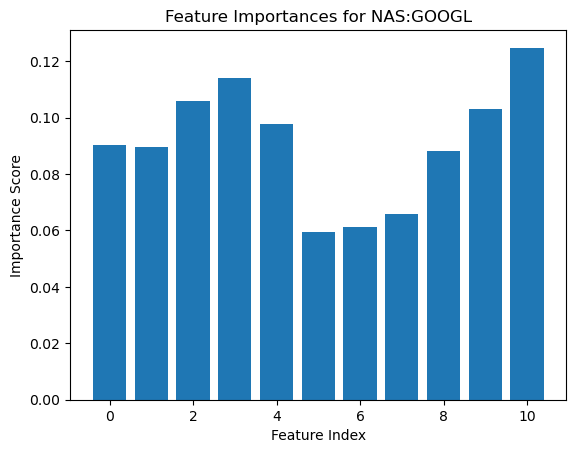

In [11]:
# Showing which features are more important in predicting:
selected_string = 'NAS:GOOGL' 
model = models[selected_string]

# Get feature importances
importance = model.feature_importances_

# Print feature importances
for i, v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i, v))

# Plotting the feature importances
plt.bar([x for x in range(len(importance))], importance)
plt.xlabel('Feature Index')
plt.ylabel('Importance Score')
plt.title(f'Feature Importances for {selected_string}')
plt.show()

In [13]:
# Performs prediction and generates output weights:
asset_name_all = stock_data.coords["asset"].values
weights = xr.zeros_like(stock_data.sel(field="close"))

total_assets = len(asset_name_all)  # Count the total number of assets

for idx, asset_name in enumerate(asset_name_all):
    if asset_name in models:
        model = models[asset_name]
        features_all = my_features
        features_cur = features_all.sel(asset=asset_name).dropna("time", how="any")  # Use how as a keyword argument
        
        if len(features_cur.time) < 1:
            print(f"No features available for asset: {asset_name}. Skipping...")
            continue
        
        print(f"Making predictions for model {idx + 1} of {total_assets}: {asset_name}")
        
        try:
            weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = model.predict(features_cur.values)
        except KeyboardInterrupt as e:
            raise e
        except Exception as e:
            logging.exception("Model prediction failed for asset: %s", asset_name)

print("Predictions completed for all models.")
print(weights)

Making predictions for model 1 of 516: NAS:AAL
Making predictions for model 2 of 516: NAS:AAPL
Making predictions for model 3 of 516: NAS:ABNB
Making predictions for model 4 of 516: NAS:ACGL
Making predictions for model 5 of 516: NAS:ADBE
Making predictions for model 6 of 516: NAS:ADI
Making predictions for model 7 of 516: NAS:ADP
Making predictions for model 8 of 516: NAS:ADSK
Making predictions for model 9 of 516: NAS:AEP
Making predictions for model 10 of 516: NAS:AKAM
Making predictions for model 11 of 516: NAS:ALGN
Making predictions for model 12 of 516: NAS:AMAT
Making predictions for model 13 of 516: NAS:AMD
Making predictions for model 14 of 516: NAS:AMGN
Making predictions for model 15 of 516: NAS:AMZN
Making predictions for model 16 of 516: NAS:ANSS
Making predictions for model 17 of 516: NAS:APA
Making predictions for model 18 of 516: NAS:AVGO
Making predictions for model 19 of 516: NAS:AXON
Making predictions for model 20 of 516: NAS:BIIB
Making predictions for model 21 of 

In [14]:
def get_sharpe(stock_data, weights):
    """Calculates the Sharpe ratio"""
    rr = qnstats.calc_relative_return(stock_data, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe

sharpe = get_sharpe(stock_data, weights)
sharpe

10.426481685423735

The sharpe ratio using the method above follows from **forward looking**. Predictions for (let us say) 2017 know about the relation between features and targets in 2020. Let us visualize the results:

field,equity,relative_return,volatility,underwater,max_drawdown,sharpe_ratio,mean_return,bias,instruments,avg_turnover,avg_holding_time
time,,,,,,,,,,,
2025-01-06,1.611207e+09,0.005739,0.197029,0.00000,-0.265954,10.429271,2.054865,1.0,516.0,0.646157,3.056780
2025-01-07,1.614420e+09,0.001994,0.197009,0.00000,-0.265954,10.428324,2.054473,1.0,516.0,0.646181,3.056737
2025-01-08,1.624066e+09,0.005975,0.196989,0.00000,-0.265954,10.430645,2.054718,1.0,516.0,0.646171,3.056746
2025-01-10,1.610067e+09,-0.008620,0.196991,-0.00862,-0.265954,10.419833,2.052614,1.0,516.0,0.646206,3.056662
2025-01-13,1.629016e+09,0.011769,0.196978,0.00000,-0.265954,10.426482,2.053783,1.0,516.0,0.646228,3.056622


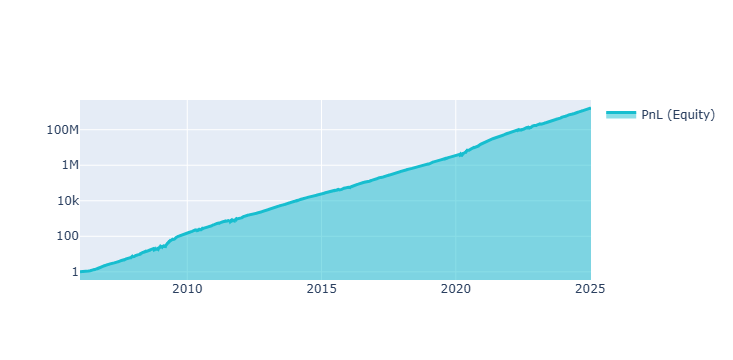

time,2025-01-13
field,
sharpe_ratio,10.426482



Ok. This strategy does not correlate with other strategies.


In [15]:
import qnt.graph as qngraph

statistics = qnstats.calc_stat(stock_data, weights)

display(statistics.to_pandas().tail())

performance = statistics.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

display(statistics[-1:].sel(field = ["sharpe_ratio"]).transpose().to_pandas())

# check for correlations with existing strategies:
qnstats.print_correlation(weights,stock_data)

In [16]:
"""R2 (coefficient of determination) regression score function."""
r2_score(my_targetclass, weights, multioutput="variance_weighted")

0.7519916189040327

In [17]:
"""The explained variance score explains the dispersion of errors of a given dataset"""
explained_variance_score(my_targetclass, weights, multioutput="uniform_average")

0.7589420476248129

In [18]:
"""The explained variance score explains the dispersion of errors of a given dataset"""
mean_absolute_error(my_targetclass, weights)

0.18297842069644454

Let us now use the Quantiacs **backtester** for avoiding **forward looking**.

The backtester performs some transformations: it trains the model on one slice of data (using only data from the past) and predicts the weights for the following slice on a rolling basis:

In [25]:
def train_model(data):
    """Create and train the model working on an asset-by-asset basis."""

    asset_name_all = data.coords["asset"].values
    features_all   = get_features(data)
    target_all     = get_target_classes(data)

    models = dict()

    for idx, asset_name in enumerate(asset_name_all):
        print(f"Training model {idx + 1} of {len(asset_name_all)}: {asset_name}")

        # Drop missing values:
        target_cur   = target_all.sel(asset=asset_name).dropna("time", how="any")
        features_cur = features_all.sel(asset=asset_name).dropna("time", how="any")

        # Align features and targets:
        target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join="inner")

        if len(features_cur.time) < 10:
            print(f"Not enough data to train the model for asset: {asset_name}. Skipping...")
            continue

        model = get_model()

        try:
            model.fit(feature_for_learn_df.values, target_for_learn_df)
            models[asset_name] = model
            print(f"Model trained successfully for asset: {asset_name}")

        except Exception as e:
            logging.exception("Model training failed for asset: %s", asset_name)

    return models

In [27]:
def predict_weights(models, data):
    """The model predicts if the price is going up or down.
       The prediction is performed for several days in order to speed up the evaluation."""

    asset_name_all = data.coords["asset"].values
    weights = xr.zeros_like(data.sel(field="close"))

    for idx, asset_name in enumerate(asset_name_all):
        if asset_name in models:
            model = models[asset_name]
            features_all = get_features(data)
            features_cur = features_all.sel(asset=asset_name).dropna("time", how="any")

            if len(features_cur.time) < 1:
                print(f"No features available for asset: {asset_name}. Skipping...")
                continue

            print(f"Making predictions for asset {idx + 1} of {len(asset_name_all)}: {asset_name}")

            try:
                weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = model.predict(features_cur.values)

            except KeyboardInterrupt as e:
                raise e

            except Exception as e:
                logging.exception("Model prediction failed for asset: %s", asset_name)

    print("Predictions completed for all models.")
    return weights

In [28]:
# Calculate weights using the backtester:
weights = qnbt.backtest_ml(
    train                         = train_model,
    predict                       = predict_weights,
    train_period                  =  2 *365,  # the data length for training in calendar days
    retrain_interval              = 10 *365,  # how often we have to retrain models (calendar days)
    retrain_interval_after_submit = 1,        # how often retrain models after submission during evaluation (calendar days)
    predict_each_day              = False,    # Is it necessary to call prediction for every day during backtesting?
                                              # Set it to True if you suspect that get_features is looking forward.
    competition_type              = "stocks_nasdaq100",  # competition type
    lookback_period               = 365,                 # how many calendar days are needed by the predict function to generate the output
    start_date                    = "2005-01-01",        # backtest start date
    analyze                       = True,
    build_plots                   = True  # do you need the chart?
)

Run the last iteration...
fetched chunk 1/1 0s
Data loaded 0s
Training model 1 of 280: NAS:AAL
Model trained successfully for asset: NAS:AAL
Training model 2 of 280: NAS:AAPL
Model trained successfully for asset: NAS:AAPL
Training model 3 of 280: NAS:ABNB
Model trained successfully for asset: NAS:ABNB
Training model 4 of 280: NAS:ADBE
Model trained successfully for asset: NAS:ADBE
Training model 5 of 280: NAS:ADCT
Not enough data to train the model for asset: NAS:ADCT. Skipping...
Training model 6 of 280: NAS:ADI
Model trained successfully for asset: NAS:ADI
Training model 7 of 280: NAS:ADP
Model trained successfully for asset: NAS:ADP
Training model 8 of 280: NAS:ADSK
Model trained successfully for asset: NAS:ADSK
Training model 9 of 280: NAS:AEP
Model trained successfully for asset: NAS:AEP
Training model 10 of 280: NAS:AKAM
Model trained successfully for asset: NAS:AKAM
Training model 11 of 280: NAS:ALGN
Model trained successfully for asset: NAS:ALGN
Training model 12 of 280: NAS:AL

  0% (0 of 5040) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Making predictions for asset 280 of 280: NYS:TEVA
Predictions completed for all models.
Training model 1 of 280: NAS:AAL
Model trained successfully for asset: NAS:AAL
Training model 2 of 280: NAS:AAPL
Model trained successfully for asset: NAS:AAPL
Training model 3 of 280: NAS:ABNB
Not enough data to train the model for asset: NAS:ABNB. Skipping...
Training model 4 of 280: NAS:ADBE
Model trained successfully for asset: NAS:ADBE
Training model 5 of 280: NAS:ADCT
Not enough data to train the model for asset: NAS:ADCT. Skipping...
Training model 6 of 280: NAS:ADI
Model trained successfully for asset: NAS:ADI
Training model 7 of 280: NAS:ADP
Model trained successfully for asset: NAS:ADP
Training model 8 of 280: NAS:ADSK
Model trained successfully for asset: NAS:ADSK
Training model 9 of 280: NAS:AEP
Model trained successfully for asset: NAS:AEP
Training model 10 of 280: NAS:AKAM
Model trained successfully for asset: NAS:AKAM
Training model 11 of 280: NAS:ALGN
Model trained successfully for a

 99% (5030 of 5040) |################### | Elapsed Time: 0:03:16 ETA:   0:00:00

Making predictions for asset 280 of 280: NYS:TEVA
Predictions completed for all models.
Training model 1 of 280: NAS:AAL
Model trained successfully for asset: NAS:AAL
Training model 2 of 280: NAS:AAPL
Model trained successfully for asset: NAS:AAPL
Training model 3 of 280: NAS:ABNB
Model trained successfully for asset: NAS:ABNB
Training model 4 of 280: NAS:ADBE
Model trained successfully for asset: NAS:ADBE
Training model 5 of 280: NAS:ADCT
Not enough data to train the model for asset: NAS:ADCT. Skipping...
Training model 6 of 280: NAS:ADI
Model trained successfully for asset: NAS:ADI
Training model 7 of 280: NAS:ADP
Model trained successfully for asset: NAS:ADP
Training model 8 of 280: NAS:ADSK
Model trained successfully for asset: NAS:ADSK
Training model 9 of 280: NAS:AEP
Model trained successfully for asset: NAS:AEP
Training model 10 of 280: NAS:AKAM
Model trained successfully for asset: NAS:AKAM
Training model 11 of 280: NAS:ALGN
Model trained successfully for asset: NAS:ALGN
Traini

 99% (5039 of 5040) |################### | Elapsed Time: 0:06:11 ETA:   0:00:19

Making predictions for asset 280 of 280: NYS:TEVA
Predictions completed for all models.
fetched chunk 1/7 0s
fetched chunk 2/7 0s
fetched chunk 3/7 0s
fetched chunk 4/7 0s
fetched chunk 5/7 0s
fetched chunk 6/7 0s
fetched chunk 7/7 0s
Data loaded 1s
Output cleaning...
fix uniq
ffill if the current price is None...
Check liquidity...
WARNING! Strategy trades non-liquid assets.
Fix liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.
Write output: /root/fractions.nc.gz
State saved.
---
Analyze results...
Check...
Check liquidity...
Ok.
Check missed dates...
Ok.
Check the sharpe ratio...
Period: 2006-01-01 - 2025-01-13
Sharpe Ratio = 0.6922228633611875


ERROR! The Sharpe Ratio is too low. 0.6922228633611875 < 0.7
Improve the strategy and make sure that the in-sample Sharpe Ratio more than 0.7.


---
Align...
Calc global stats...
---
Calc stats per asset...
Build plots...
---
Select the asset (or leave blank to display the overall stats):


interactive(children=(Combobox(value='', description='asset', options=('', 'NAS:AAL', 'NAS:AAPL', 'NAS:ABNB', …

100% (5040 of 5040) |####################| Elapsed Time: 0:07:50 Time:  0:07:50


The Sharpe ratio is obviously smaller as the training process is not looking forward (as it happens by processing data on a global basis), but performed on a rolling basis.

# May I import libraries?

Yes, please refer to the file **init.ipynb** in your home directory. You can for example use:

! conda install -y scikit-learn

# How to load data?

Daily stock data for the **Q18 Nasdaq-100** contest can be loaded using:
```python
data = qndata.stocks.load_ndx_data(tail = 17*365, dims = ("time", "field", "asset"))
```

Cryptocurrency daily data used for the Q16/Q17 contests can be loaded using:
```python
data = qndata.cryptodaily.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

Futures data for the Q15 contest can be loaded using:
```python
data= qndata.futures.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

BTC Futures data for the Q15 contest can be loaded using:
```python
data= qndata.cryptofutures.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

# How to view a list of all tickers?

```python
data.asset.to_pandas().to_list()
```

# How to see which fields are available?

```python
data.field.to_pandas().to_list()
```

# How to load specific tickers?

```python
data = qndata.stocks.load_ndx_data(tail=17 * 365, assets=["NAS:AAPL", "NAS:AMZN"])
```

# How to select specific tickers after loading all data?

```python
def get_data_filter(data, assets):
    filler= data.sel(asset=assets)
    return filler

get_data_filter(data, ["NAS:AAPL", "NAS:AMZN"])
```

# How to get the prices for the previous day?

```python
qnta.shift(data.sel(field="open"), periods=1)
```

or:

```python
data.sel(field="open").shift(time=1)
```

# How to get the Sharpe ratio?

```python
import qnt.stats as qnstats

def get_sharpe(market_data, weights):
    rr = qnstats.calc_relative_return(market_data, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe

sharpe = get_sharpe(data, weights) # weights.sel(time=slice("2006-01-01",None))
```

# How do I get a list of the top 3 assets ranked by Sharpe ratio?

```python
import qnt.stats as qnstats

data = qndata.stocks.load_ndx_data(tail = 17*365, dims = ("time", "field", "asset"))

def get_best_instruments(data, weights, top_size):
    # compute statistics:
    stats_per_asset = qnstats.calc_stat(data, weights, per_asset=True)
    # calculate ranks of assets by "sharpe_ratio":
    ranks = (-stats_per_asset.sel(field="sharpe_ratio")).rank("asset")
    # select top assets by rank "top_period" days ago:
    top_period = 1
    rank = ranks.isel(time=-top_period)
    top = rank.where(rank <= top_size).dropna("asset").asset

    # select top stats:
    top_stats = stats_per_asset.sel(asset=top.values)

    # print results:
    print("SR tail of the top assets:")
    display(top_stats.sel(field="sharpe_ratio").to_pandas().tail())

    print("avg SR = ", top_stats[-top_period:].sel(field="sharpe_ratio").mean("asset")[-1].item())
    display(top_stats)
    return top_stats.coords["asset"].values

get_best_instruments(data, weights, 3)
```

# How can I check the results for only the top 3 assets ranked by Sharpe ratio?

Select the top assets and then load their data:

```python
best_assets= get_best_instruments(data, weights, 3)

data= qndata.stocks.load_ndx_data(tail = 17*365, assets=best_assets)
```

# How can prices be processed?

Simply import standard libraries, for example **numpy**:

```python
import numpy as np

high= np.log(data.sel(field="high"))
```

# How can you reduce slippage impace when trading?

Just apply some technique to reduce turnover:

```python
def get_lower_slippage(weights, rolling_time=6):
    return weights.rolling({"time": rolling_time}).max()

improved_weights = get_lower_slippage(weights, rolling_time=6)
```

# How to use technical analysis indicators?

For available indicators see the source code of the library: /qnt/ta

## ATR

```python
def get_atr(data, days=14):
    high = data.sel(field="high") * 1.0
    low  = data.sel(field="low") * 1.0
    close= data.sel(field="close") * 1.0

    return qnta.atr(high, low, close, days)

atr= get_atr(data, days=14)
```

## EMA

```python
prices= data.sel(field="high")
prices_ema= qnta.ema(prices, 15)
```

## TRIX

```python
prices= data.sel(field="high")
prices_trix= qnta.trix(prices, 15)
```

## ADL and EMA

```python
adl= qnta.ad_line(data.sel(field="close")) * 1.0
adl_ema= qnta.ema(adl, 18)
```

# How can you check the quality of your strategy?

```python
import qnt.output as qnout
qnout.check(weights, data, "stocks_nasdaq100")
```

or

```python
stat= qnstats.calc_stat(data, weights)
display(stat.to_pandas().tail())
```

or

```python
import qnt.graph   as qngraph
statistics= qnstats.calc_stat(data, weights)
display(statistics.to_pandas().tail())

performance= statistics.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

display(statistics[-1:].sel(field = ["sharpe_ratio"]).transpose().to_pandas())
qnstats.print_correlation(weights, data)

```

# An example using pandas

One can work with pandas DataFrames at intermediate steps and at the end convert them to xarray data structures:

```python
def get_price_pct_change(prices):
    prices_pandas = prices.to_pandas()
    assets = data.coords["asset"].values
    for asset in assets:
        prices_pandas[asset] = prices_pandas[asset].pct_change()
    return prices_pandas

prices = data.sel(field="close") * 1.0
prices_pct_change = get_price_pct_change(prices).unstack().to_xarray()
```

# How to submit a strategy to the competition?

Check that weights are fine:

```python
import qnt.output as qnout
qnout.check(weights, data, "stocks_nasdaq100")
```

If everything is ok, write the weights to file:

```python
qnout.write(weights)
```

In your **personal account**:

* **choose** a strategy;
* click on the **Submit** button;
* select the type of competition.

At the beginning you will find the strategy under the **Checking** area:

* **Sent strategies** > **Checking**.

If technical checks are successful, the strategy will go under the **Candidates** area:

* **Sent strategies** > **Candidates**.

Otherwise it will be **Filtered**:

* **Sent strategies** > **Filtered**

and you should inspect error and warning messages.

Note that a strategy under the **Candidates** area should have a Sharpe ratio larger than 1 for being eligible for a prize. Please check warning messages in your **Candidates** area!